### This notebook is about different genres.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.helpers import create_graph_from_data, get_connected_components, get_communities
from src.utils.helpers import merge_movies_and_actors, filter_by_country, drop_nans, fix_date, filter_by_language, filter_by_genre
from src.data import load_characters, load_movies, load_plots, load_awards, load_nominations


In [2]:
movies = load_movies()
movies.Genres[2001]

'{"/m/01jfsb": "Thriller", "/m/0hn10": "LGBT", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/0219x_": "Indie", "/m/09blyk": "Psychological thriller", "/m/02n4kr": "Mystery", "/m/01z4y": "Comedy", "/m/0vgkd": "Black comedy"}'

In [3]:
actor_awards = load_awards()  
actor_nominations = load_nominations()  

actor_awards['TotalActorAwards'] = actor_awards['awards'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
actor_nominations['TotalActorNominations'] = actor_nominations['nominations'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
actor_awards = actor_awards.rename(columns={'freebase_ids': 'FreebaseActorId'})
actor_nominations = actor_nominations.rename(columns={'freebase_ids': 'FreebaseActorId'})

In [4]:
def get_dataset_by_genre(genre):
    movies = load_movies()
    characters = load_characters()


    us_movies = filter_by_country(movies, country="United States of America")
    print("Number of US movies:", us_movies.shape[0])

    us_movies = drop_nans(us_movies, column="Revenue")
    us_movies = drop_nans(us_movies, column="ReleaseDate")
    us_movies = fix_date(us_movies, column="ReleaseDate")
    us_movies  = filter_by_genre(us_movies, genre=genre)
    print("Number of US movies after dropping Nans:", us_movies.shape[0])
    us_movies = filter_by_language(us_movies, language="English Language")



    us_characters_movies = merge_movies_and_actors(us_movies, characters)
    return us_characters_movies

In [5]:
def create_graph(movies_ds):
    G_US = create_graph_from_data(movies_ds)
    print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

    connected_component_sizes = sorted(map(len, get_connected_components(G_US)), reverse=True)
    print(f"Number of components: {len(connected_component_sizes)}, sizes of top-5 components: {connected_component_sizes[:5]} ")

    communities_US = get_communities(G_US)
    community_sizes = sorted(map(len, communities_US), reverse=True)
    print(f"Number of communities: {len(communities_US)}, sizes of top-5 communities: {community_sizes[:5]} ")

    
    actor_metrics = (
        movies_ds[['FreebaseActorId']]
        .drop_duplicates()
        .merge(actor_awards[['FreebaseActorId', 'TotalActorAwards']], how='left', on='FreebaseActorId')
        .merge(actor_nominations[['FreebaseActorId', 'TotalActorNominations']], how='left', on='FreebaseActorId')
    )

    actor_metrics['TotalActorAwards'] = actor_metrics['TotalActorAwards'].fillna(0).astype(int)
    actor_metrics['TotalActorNominations'] = actor_metrics['TotalActorNominations'].fillna(0).astype(int)
    return communities_US, actor_metrics

In [6]:
def compute_cluster_metrics_actors(communities, us_characters_movies, actor_metrics):
    """
    Compute metrics for each community based on actor-level data:
    - Total revenue
    - Total actor awards
    - Total actor nominations
    - Number of actors in the community
    """
    cluster_metrics = {}

    for community_id, community_members in enumerate(communities):
        # Filter the actor for community
        community_actor_metrics = actor_metrics[actor_metrics.FreebaseActorId.isin(community_members)]

        # Calculate total awards/nominations
        total_actor_awards = community_actor_metrics['TotalActorAwards'].sum()
        total_actor_nominations = community_actor_metrics['TotalActorNominations'].sum()

        # Calculate total revenue based on movies
        community_movie_ids = us_characters_movies[us_characters_movies.FreebaseActorId.isin(community_members)].FreebaseId.unique()
        total_revenue = us_characters_movies[us_characters_movies.FreebaseId.isin(community_movie_ids)]['Revenue'].sum()
        total_revenue_in_billions = total_revenue / 1_000_000_000

        cluster_metrics[community_id] = {
            "total_revenue": float(f"{total_revenue_in_billions:.2f}"),
            "total_actor_awards": total_actor_awards,
            "total_actor_nominations": total_actor_nominations,
            "num_actors": len(community_members)
        }

    return cluster_metrics


In [7]:
def filter_name_by_dict(ds, storage):
    col = ds['MovieName'].apply(lambda x: x in storage)
    return ds[col]

In [8]:
comedie_movies = get_dataset_by_genre('Horror')
comedie_storage = set(comedie_movies.MovieName)
drama_movies = get_dataset_by_genre('Drama')
drama_storage = set(drama_movies.MovieName)

Number of US movies: 34408
Number of US movies after dropping Nans: 663
Number of US movies: 34408
Number of US movies after dropping Nans: 3429


In [9]:
comedie_movies = filter_name_by_dict(comedie_movies, drama_storage)
drama_movies = filter_name_by_dict(drama_movies, comedie_storage)

In [13]:
comedie_communties, comedie_actor_metrics = create_graph(comedie_movies)
comedie_cluster_metrics = compute_cluster_metrics_actors(comedie_communties, comedie_movies, comedie_actor_metrics)

Number of vertices: 1500, number of edges: 10821
Number of components: 41, sizes of top-5 components: [973, 48, 27, 23, 23] 
Number of communities: 61, sizes of top-5 communities: [94, 81, 68, 67, 63] 


In [14]:
total_comedie_revenues = [metrics["total_revenue"] for metrics in comedie_cluster_metrics.values()]
total_comedie_num_actors = [metrics["num_actors"] for metrics in comedie_cluster_metrics.values()]
total_comedie_actor_awards = [metrics["total_actor_awards"] for metrics in comedie_cluster_metrics.values()]

In [15]:
drama_communties, drama_actor_metrics = create_graph(drama_movies)
drama_cluster_metrics = compute_cluster_metrics_actors(drama_communties, drama_movies, drama_actor_metrics)

Number of vertices: 1497, number of edges: 11093
Number of components: 40, sizes of top-5 components: [1012, 36, 23, 23, 18] 
Number of communities: 60, sizes of top-5 communities: [76, 71, 67, 67, 65] 


In [16]:
total_drama_revenues = [metrics["total_revenue"] for metrics in drama_cluster_metrics.values()]
total_drama_num_actors = [metrics["num_actors"] for metrics in drama_cluster_metrics.values()]
total_drama_actor_awards = [metrics["total_actor_awards"] for metrics in drama_cluster_metrics.values()]

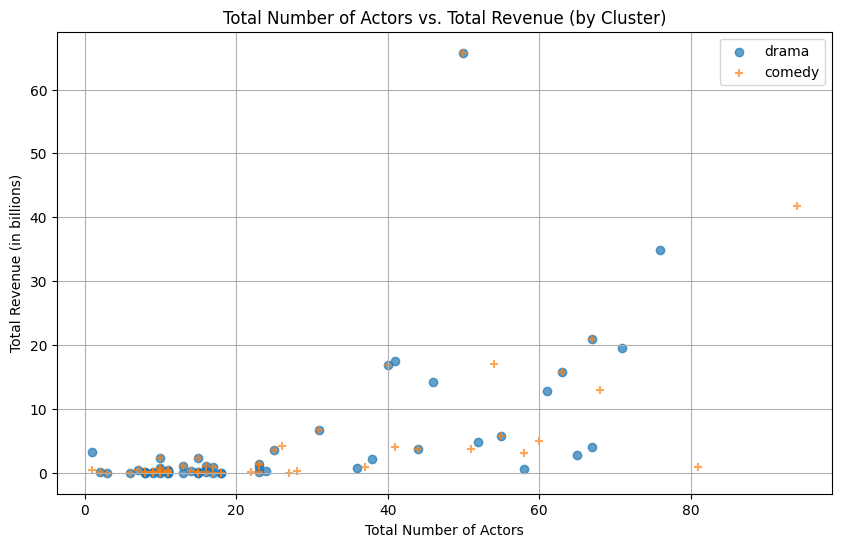

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(total_drama_num_actors, total_drama_revenues, alpha=0.7, marker='o', label='drama')
plt.scatter(total_comedie_num_actors, total_comedie_revenues, alpha=0.7, marker='+', label='comedy')

plt.title("Total Number of Actors vs. Total Revenue (by Cluster)")
plt.xlabel("Total Number of Actors")
plt.ylabel("Total Revenue (in billions)")
plt.grid(True)
plt.legend()
plt.show()